# farmsubsidy data

These examples show how to connect to the farmsubsidy database and write queries to analyze the data.

There are two possible data backends, [duckdb](https://duckdb.org/) or [clickhouse](https://clickhouse.com). They are both suitable to use for the whole dataset (~92 mio rows), while `clickhouse` performs a bit better but needs a docker container running with the imported data. `duckdb` on the other side just needs one file downloaded to your local machine and therefore it's easier to get started with it.

Data backend connection and querying is abstracted by `farmsubsidy_store.driver` no matter which backend is used. Of course, the `SQL` syntax differs a bit between the two.

Queries by the farmsubsidy driver always return a `pandas.DataFrame` that makes it really easy to continue working on data exploration and analysis. Please refer to the [pandas documentation](https://pandas.pydata.org/docs/) for more information how to use it.

## installation

A virtualenv with latest python is recommended.

This installs `farmsubsidy_store` and all it's dependencies:

`pip install git+https://github.com/okfde/farmsubsidy-store.git`

To test the installation, type `fscli --help` into your terminal.

## duckdb data backend 

To use the `duckdb` database, download the file from **HERE** and connect to it by specifying the path to it

In [1]:
%matplotlib inline
from farmsubsidy_store.drivers import get_driver

db = get_driver("duckdb", uri="./farmsubsidy.duckdb")
db

<Duckdb (./farmsubsidy.duckdb)>

Use the `query()` method to write `SQL` queries that are always returned as data frames:

In [2]:
db.query("SELECT count(*) FROM farmsubsidy")

,count_star()
0,92758711


Be careful with queries that return "large" sets of the data (or all data as shown below) – use `LIMIT`:

In [3]:
df = db.query("SELECT * FROM farmsubsidy LIMIT 100")
df.head()

,country,year,recipient_id,recipient_name,recipient_fingerprint,recipient_address,recipient_country,recipient_url,scheme,scheme_code,scheme_description,amount,currency,amount_original,currency_original
0,GB,2019,30289b89b6cd93d3766ebb43e765bf5171c614c3,,,DUNGANNON BT70,GB,,Other direct aids,,,200.10,EUR,179.83,GBP
1,GB,2019,789e7080d84d09af094186211fbaebbe288ec7f3,,,ENNISKILLEN BT74,GB,,Other direct aids,,,4.80,EUR,4.32,GBP
2,GB,2019,8873f89b5920e701822139521951b71750d35bb7,,,ENNISKILLEN BT94,GB,,Other direct aids,,,36.68,EUR,32.97,GBP
3,GB,2019,3cafb2c256a18d86e18261723a5ce0a447f77e26,,,OMAGH BT79,GB,,Other direct aids,,,2.88,EUR,2.59,GBP
4,GB,2019,3937cd2107ccedc7d3cd187e4d67b872c3b966fc,,,ENNISKILLEN BT74,GB,,Other direct aids,,,44.04,EUR,39.58,GBP


### data aggregations / analysis

Probably most interesting for data analysis are aggregation functions.

Check out the available [duckdb aggregations](https://duckdb.org/docs/sql/aggregates)

Here are a few examples:

In [4]:
# aggregation by year

df = db.query("""SELECT
    year, 
    count(*) as payments, 
    count(distinct recipient_id) as recipients, 
    sum(amount) as amount_total,
    avg(amount) as amount_avg
FROM farmsubsidy
GROUP BY year
ORDER BY year""")

df

,year,payments,recipients,amount_total,amount_avg
0,2013,491672,79461,6.256969e+09,12725.899976
1,2014,7867623,4575223,4.256369e+10,5409.981285
2,2015,7735065,3691275,3.992667e+10,5161.775006
3,2016,12744243,4165755,4.186966e+10,3285.378457
4,2017,16971086,5307745,5.259596e+10,3099.151059
5,2018,15637819,4807001,5.091151e+10,3255.665718
6,2019,16628317,5252716,5.504630e+10,3310.395050
7,2020,14273949,3765140,5.361987e+10,3756.484605
8,2021,408937,98571,1.443672e+09,3530.304398


<AxesSubplot:xlabel='year'>

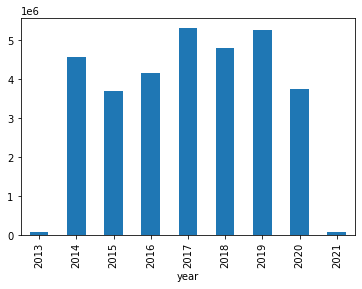

In [5]:
df = df.set_index("year")
df["recipients"].plot.bar()

In [6]:
# aggregation by year but filtered for germany ("DE")
# country codes are uppercase 2 letter iso 

df = db.query("""SELECT
    year, 
    count(*) as payments, 
    count(distinct recipient_id) as recipients, 
    sum(amount) as amount_total,
    avg(amount) as amount_avg
FROM farmsubsidy
WHERE country = 'DE'
GROUP BY year
ORDER BY year""")

df

,year,payments,recipients,amount_total,amount_avg
0,2014,520046,294310,6.823075e+09,13120.136836
1,2015,943366,298390,6.743237e+09,7148.059942
2,2016,1326870,287660,6.389865e+09,4815.743156
3,2017,1353393,285067,6.459907e+09,4773.120214
4,2018,1321944,281875,6.539245e+09,4946.688035
5,2019,1301974,278094,6.686267e+09,5135.484568
6,2020,1298807,274798,6.808693e+09,5242.266716


In [7]:
# get the top 10 recipients by amount for belgium 
# recipients can have multiple names, that's why we have to use string aggregation here

df = db.query("""SELECT
    recipient_id, 
    string_agg(recipient_name, '; ') as names,
    count(*) as payments,
    sum(amount) as amount_total
FROM farmsubsidy
WHERE country = 'BE'
GROUP BY recipient_id
ORDER BY amount_total DESC
LIMIT 10""")

df

,recipient_id,names,payments,amount_total
0,3b4bf039a2e2fafd5fcc95a30cfceb6e612a7aa7,LOGISTIEKE EN ADMINISTRATIEVE VEILINGSASSOCIAT...,5,1.343335e+08
1,1ed7c486632837c23414a042a8652b6675f6aec6,BEL321589; BEL321589; XPAIR COMMUNICATION; BEL...,47,4.184858e+07
2,906ba93542a740e71ea3fdb8548a1ee019d88e0d,BEL477836; VRIJE BASISSCHOOL SINT-JANSSCHOOL; ...,46,4.096439e+07
3,25c152387bec113b27c89ef5569a6c5560256ed8,PEETERS ACHILLE; PEETERS ACHILLE; BOERENBONDVE...,41,4.082623e+07
4,3d092a3dc1d4ad67d2697ba63e7c46ecf3c666ff,EUROPEAN CO-OPERATION - EUROPESE FRUIT COOPERA...,3,2.454850e+07
5,327e6165a7a397ff252888d550652f7b26fbfdda,BELGISCHE FRUITVEILING; BELGISCHE FRUITVEILING...,4,2.274060e+07
6,6304bf2a9318d37140d351e84c1fc71ca5b5c0b8,AGRINAT SPRL; AGRINAT SPRL; BEL00461; BEL00991...,40,1.982890e+07
7,c1c634f2f8157cb421df89b5f09d42ba53de2c98,BEL01423; BEL00081; INDIVISION DE BRIEY- DE FA...,38,1.834279e+07
8,f649eed84a936ba3c77fafbc3cd37d403ca005da,TELERSVERENIGING INDUSTRIEGROENTEN; TELERSVERE...,4,1.441141e+07
9,49ea6ad0eab3d60b1b127e4142ba4b347c56d4b2,UNIGROW; UNIGROW; UNIGROW; UNIGROW,4,9.820869e+06


## clickhouse backend

[clickhouse aggregation functions](https://clickhouse.com/docs/en/sql-reference/aggregate-functions/reference/)

Use a connection string to the running instance of clickhouse:

In [8]:
db = get_driver("clickhouse", uri="localhost")
db

<Clickhouse (localhost)>

In [9]:
db.query("SELECT count(*) FROM farmsubsidy")

,count__
0,92758711


In [10]:
df = db.query("SELECT * FROM farmsubsidy LIMIT 100")
df.head()

,pk,country,year,recipient_id,recipient_name,recipient_fingerprint,recipient_address,recipient_country,recipient_url,scheme,scheme_code,scheme_description,amount,currency,amount_original,currency_original
0,4f68596a82050233f9f818b6fa7e46ab938c3e01,AT,2014,4a7ccb6345a2a3d8cf9a2478e408f0cd962e4883,AGRARGEM. LERCHKAR 1,1 agrargem lerchkar,IRDNING-DONNERSBACHTAL 8953,AT,,Agrarumweltmaßnahmen (214),,,4995,EUR,4995,EUR
1,a9a49b636086fc0e65b4358550a3c060b1b2838a,AT,2014,07bae95094090ee325598ef43799dbf221c4de67,AGRARGEMEINSCHAFT VORDERHÜTTEN GRUPPE 1,1 agrargemeinschaft gruppe vorderhutten,STADL-PREDLITZ 8863,AT,,Agrarumweltmaßnahmen (214),,,1272,EUR,1272,EUR
2,d381d8615acad261dde8d2f83a59c72b9d5efb1a,AT,2014,ca1588dcc2416eb385f12b57ecbea58e7fa7445b,BIOS 1 BIOSUBSTRATHERSTELLUNGS- UND VERWERTUNG...,1 bios biosubstratherstellungs mbh und verwert...,BÖHEIMKIRCHEN 3071,AT,,Agrarumweltmaßnahmen (214),,,1480.69,EUR,1480.69,EUR
3,9f73fb21d7b718577d5d888c7044351d410ebb02,AT,2014,ca1588dcc2416eb385f12b57ecbea58e7fa7445b,BIOS 1 BIOSUBSTRATHERSTELLUNGS- UND VERWERTUNG...,1 bios biosubstratherstellungs mbh und verwert...,BÖHEIMKIRCHEN 3071,AT,,Betriebsprämienregelung (8),,,5090.73,EUR,5090.73,EUR
4,ef64a95c13382560cf522c1357a4cada0fb0a25a,AT,2014,3faae0613eec9d75d52a32194c4ae472d9202cf5,JAGDGESELLSCHAFT ILLMITZ 1,1 illmitz jagdgesellschaft,ILLMITZ 7142,AT,,Ausgleichszahlungen für andere benachteiligte ...,,,624.6,EUR,624.6,EUR


In [11]:
df = db.query("""SELECT
    year, 
    count(*) as payments, 
    count(distinct recipient_id) as recipients, 
    sum(amount) as amount_total,
    avg(amount) as amount_avg
FROM farmsubsidy
WHERE country = 'DE'
GROUP BY year
ORDER BY year""")

df

,year,payments,recipients,amount_total,amount_avg
0,2014,520046,294310,6823074681.04,13120.136836
1,2015,943366,298390,6743236714.87,7148.059942
2,2016,1326870,287660,6389865121.45,4815.743156
3,2017,1353393,285067,6459907485.32,4773.120214
4,2018,1321944,281875,6539244567.39,4946.688035
5,2019,1301974,278094,6686267385.44,5135.484568
6,2020,1298807,274798,6808692706.68,5242.266716


In [12]:
# get the top 10 recipients by amount for belgium 
# recipients can have multiple names, that's why we have to use string aggregation here

df = db.query("""SELECT
    recipient_id, 
    groupUniqArray(recipient_name) as names,
    count(*) as payments,
    sum(amount) as amount_total
FROM farmsubsidy
WHERE country = 'BE'
GROUP BY recipient_id
ORDER BY amount_total DESC
LIMIT 10""")

df

,recipient_id,names,payments,amount_total
0,3b4bf039a2e2fafd5fcc95a30cfceb6e612a7aa7,[LOGISTIEKE EN ADMINISTRATIEVE VEILINGSASSOCIA...,5,134333529.99
1,1ed7c486632837c23414a042a8652b6675f6aec6,"[BEL337948, XPAIR COMMUNICATION, BB CONSULT, S...",47,41848582.8
2,906ba93542a740e71ea3fdb8548a1ee019d88e0d,"[GO! FREINETSCHOOL DE APPELTUINLEUVEN, BEL4754...",46,40964393.63
3,25c152387bec113b27c89ef5569a6c5560256ed8,"[BEL07531, BEL04979, STEUNPUNT GROENE ZORG, SB...",41,40826233.72
4,3d092a3dc1d4ad67d2697ba63e7c46ecf3c666ff,[EUROPEAN CO-OPERATION - EUROPESE FRUIT COOPER...,3,24548495.82
5,327e6165a7a397ff252888d550652f7b26fbfdda,[BELGISCHE FRUITVEILING],4,22740603.96
6,6304bf2a9318d37140d351e84c1fc71ca5b5c0b8,"[AGRINAT SPRL, BEL00461, BEL00991, TILMANT MAR...",40,19828903.83
7,c1c634f2f8157cb421df89b5f09d42ba53de2c98,"[BEL01085, BEL00967, VLAAMS CENTRUM VOOR AGRO-...",38,18342790.12
8,f649eed84a936ba3c77fafbc3cd37d403ca005da,[TELERSVERENIGING INDUSTRIEGROENTEN],4,14411412.07
9,49ea6ad0eab3d60b1b127e4142ba4b347c56d4b2,[UNIGROW],4,9820869.39
